# Baseline Model
## Game of Thrones Text Classification
### T. P. Goter
### W266 Final Project
### Fall 2019

This notebook is used to generate a Naive Bayes model for text classification using training data generated for the Game of Thrones novel. A simple GridSearch with cross validation is done for each model in order to empirically determine the best parameter of for smoothing (i.e., alpha). Both unigram and bigram models are considered. Additionally, consideration is given to a tfidf vectorication vice a simple word count vectorization. The results of these studies show that all four models perform about the same and have precision, recall and f1 scores near 0.70. Class 5 (i.e., Book 5) shows as the most easily predicted. This isn't really surprising given books four and five were focused on a subset of the characters. Thus, word counts of character names likely are better indicators for these books. With 70% accuracy as our baseline score on the development set, there is plenty of room for further improvement with BERT and the UDA techniques.

In [18]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# import the tokenization module
from utils import tokenization

## Load Data
For consistency between our BERT, XLNet and baseline models, we want to use the same subsets of training examples. We do this by reading in the already pre-processed datasets that were generated for the BERT evaluations. As such these examples are already tokenized. For a Naive-Bayes classifier, this should not be an issue, but it is something to be aware of.

In [19]:
# Read the data into dataframes stored in a dictionary
dfs = {}
for case in 'train dev test'.split():
    if case == 'train':
        for exs in '20 200 2000 5000 12000'.split():
            case = 'train_{}'.format(exs)
            dfs[case] = pd.read_pickle(os.path.join('Data/proc_data/GoT',case,case + '.pkl'))
    else:
        dfs[case] = pd.read_pickle(os.path.join('Data/proc_data/GoT',case,case + '.pkl'))

print(dfs.keys())

dict_keys(['train_20', 'train_200', 'train_2000', 'train_5000', 'train_12000', 'dev', 'test'])


In [20]:
def create_basic_model(df_train, df_dev, bigram=False, tfidf=False, tokenize=False):
    '''
    Function to train and evalute a multinomial naive bayes model.
    :param: bigram: Boolean, use unigram and bigrams
    :param: tfidf: Boolean, use tfidf weighting during feature vectorization
    :param: tokenize: Boolean, use WordPiece tokenization with BERT input vocabulary
    '''
    # Set up a range of alphas to test
    alphas = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
     
    # Get data and labels from dataframe   
    train_data = df_train.seq
    train_y = df_train.label
    dev_data = df_dev.seq
    dev_y = df_dev.label
    
    # Instantiate the count vectorizer
    if bigram:
        if tfidf:
            vectorizer = TfidfVectorizer(ngram_range=(1,2))
        else:
            vectorizer = CountVectorizer(ngram_range=(1,2))
    else:
        if tfidf:
            vectorizer = TfidfVectorizer()
        else:
            vectorizer = CountVectorizer()
    
    # Generate the Feature Vectors
    train_X = vectorizer.fit_transform(train_data)    
    
    # Generate the vocabulary for the dev data
    dev_X = vectorizer.transform(dev_data)
       
    # Fit the model
    clf = MultinomialNB()
    
    # Run a grid search over alpha (smoothing) values to determine best 
    gs_clf = GridSearchCV(clf, param_grid=alphas, cv=4, return_train_score=True)
    gs_clf.fit(train_X, train_y)
    
    # Display the best parameter
    print(50 * "=")
    print("The best alpha value was determined to be {}".format(gs_clf.best_params_['alpha']))
    print(50 * "=")

    # Let's make some predictions using the best classifier
    y_pred = gs_clf.best_estimator_.predict(dev_X)
    
    # Calculate Accuracy and Error Rate
    acc = sum(dev_y==y_pred)/len(dev_y)
    err_rate = 1- acc
       
    print("Accuracy: {:0.3f}".format(acc))
    print(50 * "=")
    print(classification_report(y_pred, dev_y))
    print(confusion_matrix(dev_y, y_pred))
    
    return err_rate


## Basic Unigram Model

Metrics we will consider are precision, recall, and F1-score. Remember that:

- Precision: Number of items labeled as class A that are actually class A. - How many false positives?
- Recall: Number of items labeled as class A normalized to all things that are class A. - How many false negatives?
- F1 Score: Harmonic mean of Precision and Recall


In [21]:
uni_error = create_basic_model(dfs['train_12000'], dfs['dev'])

The best alpha value was determined to be 1.0
Accuracy: 0.665
              precision    recall  f1-score   support

           1       0.79      0.62      0.70       536
           2       0.53      0.61      0.57       426
           3       0.56      0.64      0.60       520
           4       0.78      0.65      0.71       493
           5       0.70      0.78      0.74       526

   micro avg       0.66      0.66      0.66      2501
   macro avg       0.67      0.66      0.66      2501
weighted avg       0.68      0.66      0.67      2501

[[335  36  29  13  11]
 [ 92 261  71  38  27]
 [ 70  84 333  55  50]
 [ 11  16  37 321  26]
 [ 28  29  50  66 412]]


## Bigram Model

In [22]:
bi_error = create_basic_model(dfs['train_12000'], dfs['dev'], bigram=True)

The best alpha value was determined to be 0.5
Accuracy: 0.705
              precision    recall  f1-score   support

           1       0.83      0.65      0.72       542
           2       0.59      0.66      0.63       439
           3       0.61      0.72      0.66       500
           4       0.84      0.67      0.75       514
           5       0.72      0.83      0.77       506

   micro avg       0.71      0.71      0.71      2501
   macro avg       0.72      0.71      0.70      2501
weighted avg       0.72      0.71      0.71      2501

[[350  39  21   9   5]
 [ 95 290  54  32  18]
 [ 60  70 359  58  45]
 [ 13  17  16 346  19]
 [ 24  23  50  69 419]]


In [26]:
dfs['dev'].label.value_counts()

3    592
5    585
2    489
1    424
4    411
Name: label, dtype: int64

## Unigram Model with Tf-Idf Weighting

In [25]:
uni_tfidf_error = create_basic_model(dfs['train_12000'], dfs['dev'], tfidf=True)

The best alpha value was determined to be 0.5
Accuracy: 0.656
              precision    recall  f1-score   support

           1       0.80      0.61      0.69       559
           2       0.52      0.62      0.57       410
           3       0.58      0.63      0.60       545
           4       0.76      0.64      0.70       489
           5       0.67      0.79      0.73       498

   micro avg       0.66      0.66      0.66      2501
   macro avg       0.67      0.66      0.66      2501
weighted avg       0.67      0.66      0.66      2501

[[340  33  32  10   9]
 [100 254  74  37  24]
 [ 72  79 341  56  44]
 [ 17  17  36 313  28]
 [ 30  27  62  73 393]]


## Bigram Model with Tf-Idf Weighting

In [27]:
bi_tfidf_error = create_basic_model(dfs['train_12000'], dfs['dev'], tfidf=True, bigram=True)

The best alpha value was determined to be 0.1
Accuracy: 0.711
              precision    recall  f1-score   support

           1       0.83      0.65      0.73       539
           2       0.59      0.68      0.63       423
           3       0.63      0.70      0.66       528
           4       0.83      0.68      0.75       506
           5       0.73      0.84      0.78       505

   micro avg       0.71      0.71      0.71      2501
   macro avg       0.72      0.71      0.71      2501
weighted avg       0.73      0.71      0.71      2501

[[351  34  26   8   5]
 [ 98 288  58  31  14]
 [ 58  67 371  55  41]
 [ 13  16  19 343  20]
 [ 19  18  54  69 425]]


## Baseline Evaluations
Based on the simple model sensitivites performed above, we will use a bigram NaiveBayes model with a simple CountVectorizer as our baseline model. We will evaluate baseline performance on all subsets of training data and generate results based on evaluation on the test set.

In [28]:
bi_error_12000 = create_basic_model(dfs['train_12000'], dfs['test'], bigram=True)

The best alpha value was determined to be 0.5
Accuracy: 0.678
              precision    recall  f1-score   support

           1       0.84      0.62      0.71       428
           2       0.57      0.65      0.61       345
           3       0.54      0.62      0.58       383
           4       0.81      0.69      0.75       367
           5       0.70      0.80      0.74       415

   micro avg       0.68      0.68      0.68      1938
   macro avg       0.69      0.68      0.68      1938
weighted avg       0.70      0.68      0.68      1938

[[265  25  19   3   2]
 [ 76 225  53  24  19]
 [ 41  63 239  46  50]
 [ 12  10  25 255  14]
 [ 34  22  47  39 330]]


In [29]:
bi_error_5000 = create_basic_model(dfs['train_5000'], dfs['test'], bigram=True)

The best alpha value was determined to be 0.5
Accuracy: 0.618
              precision    recall  f1-score   support

           1       0.82      0.54      0.65       477
           2       0.50      0.59      0.54       332
           3       0.42      0.55      0.47       334
           4       0.76      0.66      0.71       362
           5       0.68      0.74      0.71       433

   micro avg       0.62      0.62      0.62      1938
   macro avg       0.63      0.62      0.62      1938
weighted avg       0.65      0.62      0.62      1938

[[258  29  18   7   2]
 [ 96 197  55  25  24]
 [ 63  69 183  52  72]
 [ 20  15  28 239  14]
 [ 40  22  50  39 321]]


In [30]:
bi_error_2000 = create_basic_model(dfs['train_2000'], dfs['test'], bigram=True)

The best alpha value was determined to be 0.5
Accuracy: 0.578
              precision    recall  f1-score   support

           1       0.82      0.51      0.63       499
           2       0.45      0.53      0.48       335
           3       0.39      0.49      0.43       346
           4       0.74      0.61      0.67       386
           5       0.60      0.76      0.67       372

   micro avg       0.58      0.58      0.58      1938
   macro avg       0.60      0.58      0.58      1938
weighted avg       0.62      0.58      0.58      1938

[[256  27  22   6   3]
 [ 96 177  65  39  20]
 [ 72  79 170  65  53]
 [ 22  18  29 234  13]
 [ 53  34  60  42 283]]


In [31]:
bi_error_200 = create_basic_model(dfs['train_200'], dfs['test'], bigram=True)

The best alpha value was determined to be 1.0
Accuracy: 0.378
              precision    recall  f1-score   support

           1       0.58      0.40      0.47       457
           2       0.18      0.36      0.24       199
           3       0.39      0.30      0.34       574
           4       0.45      0.37      0.40       385
           5       0.36      0.52      0.43       323

   micro avg       0.38      0.38      0.38      1938
   macro avg       0.39      0.39      0.37      1938
weighted avg       0.42      0.38      0.39      1938

[[181  17  72  25  19]
 [ 85  71 137  67  37]
 [ 84  54 170  76  55]
 [ 36  30  66 141  43]
 [ 71  27 129  76 169]]


In [32]:
bi_error_20 = create_basic_model(dfs['train_20'], dfs['test'], bigram=True)

The best alpha value was determined to be 0.5
Accuracy: 0.253
              precision    recall  f1-score   support

           1       0.26      0.29      0.27       285
           2       0.09      0.20      0.12       178
           3       0.65      0.25      0.36      1161
           4       0.15      0.21      0.17       218
           5       0.09      0.44      0.15        96

   micro avg       0.25      0.25      0.25      1938
   macro avg       0.25      0.28      0.21      1938
weighted avg       0.46      0.25      0.29      1938

[[ 82  24 177  28   3]
 [ 58  35 235  51  18]
 [ 45  44 285  42  23]
 [ 32  32 196  46  10]
 [ 68  43 268  51  42]]


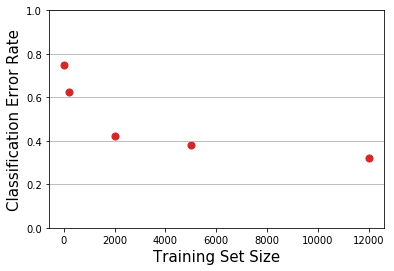

In [55]:
error_rates = np.array([bi_error_20, bi_error_200, bi_error_2000, bi_error_5000, bi_error_12000])
training_data_sizes = np.array([20,200,2000,5000,12000])
fig, ax = plt.subplots()
plt.scatter(training_data_sizes, error_rates, c='tab:red',s=50)
ax.set(ylim=(0,1.0))
plt.xlabel('Training Set Size', fontsize=15)
plt.ylabel('Classification Error Rate', fontsize=15)
plt.grid(True,axis='y')
plt.savefig('report/working/baseline.png')

In [56]:
error_rates

array([0.74716202, 0.62229102, 0.42208462, 0.38183695, 0.32198142])

In [57]:
error_df = pd.DataFrame()
error_df['bl_errors'] = error_rates
error_df['datasets'] = training_data_sizes
error_df.to_pickle('./errors.pkl')